In [1]:
from langgraph.graph import StateGraph,add_messages
from typing import TypedDict,Annotated,List,Optional
from langchain.tools import tool
from langchain_openai import ChatOpenAI
import pyodbc
from langchain_core.messages import HumanMessage,AIMessage,RemoveMessage,BaseMessage,ToolMessage
from prompts import request_document_system_message
from pydantic import Field,BaseModel
import requests
import os
from langgraph.types import interrupt,Command
from langgraph.graph import START,END
from langgraph.checkpoint.memory import MemorySaver
import time
import uuid

checkpointer = MemorySaver()


In [ ]:
class DocumentState(TypedDict):
    messages : Annotated[list[str],add_messages]
    summary : str
    human_interrupt : bool
    interrupt_question : str

class ToolCall(BaseModel):
    name: str = Field(
        description=(
            "The name of the tool to invoke. Must exactly match one of the registered tools. "
            "Tool calls should ONLY be generated if ALL required arguments are available. "
            "If arguments are missing or ambiguous, do not create a tool call — instead set human_interrupt=True."
        )
    )
    arguments: Optional[dict] = Field(
        default=None,
        description=(
            "The arguments for the tool as key-value pairs. "
            "Must include ALL required parameters for the chosen tool. "
            "If not available, set human_interrupt=True and do not include the tool call."
        ),
    )

class DocLlmSchema(BaseModel):
    message: Optional[List[str]] = Field(
        default=None,
        description=(
            "A list of outputs generated by the model. "
            "Each item can be either a direct textual response for the user "
            "or the name of a tool/function that should be invoked. "
            "If multiple steps are required, include them in order."
            "if tool calls are required then this field should be null." \
            "**IMPORTANT**: Tool calls can only be made when all input arguments are available "
        )
    )
    tool_call: Optional[List[ToolCall]] = Field(
        description="single or list of tool calls required to complete the given task"
    )
    human_interrupt: bool = Field(
        default=False,
        description=(
            "Set to True if the model does not have enough clarity or confidence "
            "to act on the query directly. In such cases, the model must ask the user "
            "for clarification before proceeding. False if the model is certain."
        )
    )
    interrupt_question: Optional[str] = Field(
        default=None,
        description=(
            "A natural-language follow-up question that the model should ask the user "
            "to resolve uncertainty. Only required when human_interrupt is True; "
            "otherwise this field should be None."
        )
    )


class requestobject(TypedDict):
    document_name : list[str] = Field(description="original name of the document from the available list")
    matching_percentage : int = Field(description = "An integer describing matching percentage between 1 to 100")

# Define input schema for better parameter extraction
class DocumentDownloadInput(BaseModel):
    webtop_id: str = Field(description="An alphanumeric id for which the document needs to be downloaded. Example: '464PZ8600789'")
    document_name: str = Field(description="Name of the document to be downloaded. Example: 'vm summary', 'Loan Agreement', 'Aadhar card'")

class FetchToolInput(BaseModel):
    webtop_id: str = Field(description="An alphanumeric id unique id for which document download progress will be checked. Example: '464PZ8600789'")
    document_name: str = Field(description="Document name whose progress needs to be checked for given webtop_id. Example: 'vm summary', 'Loan Agreement', 'Aadhar card'")


llm = ChatOpenAI(model = 'gpt-4o-mini',a,temperature =0)


In [3]:
# tools


def insert_task_record(work_id: str, webtop_id: str, document_name: str) -> bool:
    """
    Inserts a new task record into the Task_Test table.

    Args:
        work_id (str): Work ID of the task.
        webtop_id (str): Application/Webtop ID.
        document_name (str): Name of the document.

    Returns:
        bool: True if insert was successful, False otherwise.
    """

    query = """
        INSERT INTO [CustomerSupportGPT].[dbo].[Task_Test] 
        (Work_ID, Application_ID, Task_Name, Task_Status, Doc_Name)
        VALUES (?, ?, 'request', 'New', ?)
    """

    conn_str = (
        "DRIVER={ODBC Driver 17 for SQL Server};"
        "SERVER=216.48.191.98;"
        "DATABASE=CustomerSupportGPT;"
        "UID=ibsadmin;"
        "PWD=Viking@@ibs2023;"
    )

    try:
        with pyodbc.connect(conn_str, autocommit=True) as conn:
            cursor = conn.cursor()
            cursor.execute(query, (work_id, webtop_id, document_name))
            print(f"✅ Insert successful for Work_ID={work_id}, Webtop_ID={webtop_id}")
            return True
    except Exception as e:
        print(f"❌ Error inserting record: {e}")
        return False


def execute_sql_query(query : str) -> list:

    """
    Executes a SQL SELECT query on the SQL Server and returns the results as a list of dicts.
    
    Parameters:
        query (str): A SELECT query string.
    
    Returns:
        List[dict]: List of rows as dictionaries.
    """
    

    conn_str = (
        "DRIVER={ODBC Driver 17 for SQL Server};"
        "SERVER=216.48.191.98;"
        "DATABASE=Doc_Repository;"  # or Kredit_Bee_FC based on query
        "UID=ibsadmin;"
        "PWD=Viking@@ibs2023;"
    )
    try:
        with pyodbc.connect(conn_str) as conn:
            print("✅ Connection successful!")
    except Exception as e:
        print("❌ Connection failed:", e)
    try:
        with pyodbc.connect(conn_str, autocommit=True) as conn:
            cursor = conn.cursor()
            cursor.execute(query)
            columns = [column[0] for column in cursor.description]
            rows = cursor.fetchall()
            results = [dict(zip(columns, row)) for row in rows]
            print(f"✅ Query executed successfully. Rows fetched: {len(results)}")
            document_names = []
            for value in results:
                document_names.extend(value.values())
            document_names = ", ".join(document_names)
            return document_names
    except Exception as e:
        print(f"❌ Error executing query: {e}")
        return []

@tool(args_schema=FetchToolInput)
def fetch_tool(webtop_id : str , document_name : str) -> str:
    """
    check status of the document for download.

    input:
        webtop_id (str): An alphanumeric id unique id for which document download progress will be checked.
                             Example : "464PZ8600789"

        document_name (str):Original Name of the document fetched from Document_download tool whose progress needs to be checked for given webtop_id
                             Example : "vm summary", "Loan Agreement", "Aadhar card"

    
    output:
        str : status of document
    """

    query = f"select top(1)[Task_Status]  from [CustomerSupportGPT].[dbo].[Task_Test] where Application_ID = '{webtop_id}' and Doc_Name = '{document_name}'"

    print(query)



    while True:
        
        response = execute_sql_query(query)
        # print(response)
        if response == 'Completed':
            return 'Document has been downloaded'
        
        elif response =='Business Exception':
            return "the requested document was not found on document management system portal"

        elif response == "System Exception":
            return "there was some internal error while downloading the document please try again later"


@tool
def document_download(webtop_id : str, document_name : str) -> str:
    """
    download the document for given document name from DMS(Document Management System) portal.
    
    Input:
        webtop_id (str): An alphanumeric id for which the document needs to be downloaded.
                             Example : "464PZ8600789"

        document_name (str): Name of the document to be downloaded
                             Example : "vm summary", "Loan Agreement", "Aadhar card"

    Output:
        str : status code if the request for document download was hit successfully followed by the original document name which was used to start download process and if request was not completed then the reason for not download of that document.

    """
    
    print(f'getting data list.... for {webtop_id} and document {document_name}')

    query_to_fetch_list = "select Doc_Name from [Doc_Repository].[dbo].[Document_List_Master] where Process_ID = 'D000'"

    data = execute_sql_query(query_to_fetch_list)

    print(data)

    print("fetched data list....")

    response = llm.with_structured_output(requestobject).invoke([
        HumanMessage(content=request_document_system_message.format(
            document=document_name, 
            Document_List=data
    
        ))
    ])

    print(f"model response : {response.get('document_name')} , {len(response.get('document_name'))}")

    if type(response.get('document_name')) == str:
        response["document_name"] == [response.get('document_name')]


    if len(response.get('document_name')) > 1:
        # result = interrupt(f"""please select which document you want to download from these matchin names for your given name :
        #                 {response.get('document_name')}""")
        
        # response['document_name'] = [result]
        return f"tool was not executed because it found {response.get('document_name')} multiple document names please select one of the name and call the tool again"
    
    
    print(f"\n\n{response.get('document_name')} : {len(response.get('document_name'))}\n\n")
    
    if len(response.get('document_name')) == 1:

        data = {
        "Webtop_ID": webtop_id,
        "Process_Name": "CustomerVerification",
        "Work_ID": "123456",
        "Task_Name": "CheckCibil",
        "DocNames": response.get('document_name')[0],
        "DocFolderPath": r"C:\\CustomerSupportGPT\\Documents",
        "ScriptPath": "C:\\Credit_GPT\\Process\\Supporting Files\\DMS_DOC_FETCH_API.py",
        "ErrorFilePath": "C:\Credit_GPT\Process\Supporting Files\Error.txt",
        "Doc_Path": "C:\\CustomerSupportGPT\\Documents",
        "sTo_mail": "abhirajsingh.rajpurohit@idolizesolutions.com",
        "Subject_line": "Document Processing Completed",
        "sMail_body": "Your document has been processed successfully."}


        print("score : ",response.get('matching_percentage'),"  document name : ",response.get('document_name'))
        if response.get('matching_percentage') > 50:
            print(os.getenv('DOCUMENT_DOWNLOAD_FLOW_URL',''))
            insert_task_record('1234', webtop_id, response.get('document_name')[0])
            # resp = requests.post("https://prod-09.centralindia.logic.azure.com:443/workflows/c2d24b472afd4bf59284a6a7af9b479b/triggers/manual/paths/invoke?api-version=2016-06-01&sp=%2Ftriggers%2Fmanual%2Frun&sv=1.0&sig=5q3charGoRRbc0AWvLm_BsgyzO6LnjiO-lm6M4JLT8A", json=data, timeout=30)
            resp = requests.post("https://defaultb27025bdc085406fb4beacc54b08a9.91.environment.api.powerplatform.com:443/powerautomate/automations/direct/workflows/b598f83b71a74530a39df5e5118762bd/triggers/manual/paths/invoke?api-version=1&sp=%2Ftriggers%2Fmanual%2Frun&sv=1.0&sig=dQ2xP5EC4fkHvBPgvfLEzOkvrRqN0vRzdszvUEy7LzY", json=data, timeout=30)

            print(f"{resp.status_code} {resp.text}")

            return f"202  {response.get('document_name')[0]}"
            # return f"{resp.status_code} {resp.text} {response.get('document_name')[0]}"

        else :

            return "could not find any document in database that matches your provided document name"
        
    elif len(response.get('document_name')) == 0:
        return "no matching document name was found for the given document, no document download process started"
    else :  
        return "error occured while execution try again"



<>:182: SyntaxWarning: invalid escape sequence '\C'
<>:182: SyntaxWarning: invalid escape sequence '\C'
C:\Users\admin\AppData\Local\Temp\ipykernel_6580\2320033963.py:182: SyntaxWarning: invalid escape sequence '\C'
  "ErrorFilePath": "C:\Credit_GPT\Process\Supporting Files\Error.txt",


In [4]:
TOOL = [document_download, fetch_tool]
tools_by_name = {tool.name: tool for tool in TOOL}
llm_with_tools = llm.bind_tools(TOOL)

tools_by_name

{'document_download': StructuredTool(name='document_download', description='download the document for given document name from DMS(Document Management System) portal.\n\nInput:\n    webtop_id (str): An alphanumeric id for which the document needs to be downloaded.\n                         Example : "464PZ8600789"\n\n    document_name (str): Name of the document to be downloaded\n                         Example : "vm summary", "Loan Agreement", "Aadhar card"\n\nOutput:\n    str : status code if the request for document download was hit successfully followed by the original document name which was used to start download process and if request was not completed then the reason for not download of that document.', args_schema=<class 'langchain_core.utils.pydantic.document_download'>, func=<function document_download at 0x000001E81C5E94E0>),
 'fetch_tool': StructuredTool(name='fetch_tool', description='check status of the document for download.\n\ninput:\n    webtop_id (str): An alphanume

In [5]:
system_message = """

<BEHAVIOUR>

You are an AI assistant that decides between responding directly to the user
or invoking backend tools.

</BEHAVIOUR>

<STRICT RULES>
1. Only generate tool calls if ALL required arguments are fully provided in the user request.
2. If any required argument is missing, unclear, or ambiguous:
   - Do NOT generate a tool call.
   - Instead set human_interrupt=True and provide a clarifying question in interrupt_question.
3. If responding directly without tools, write a helpful answer in `message`.
4. If tool calls are required, `message` must be null.
5. Tool names must exactly match the registered tool list: [document_download, fetch_tool].
6. For document download flows:
   - If a document must be downloaded, first call `document_download`.
   - After that, call `fetch_tool` to check its progress.
   - **IMPORTANT** : `fetch tool` takes the document name as input which is provided as response from document download tool(status code should be excluded) .
   - Both calls require `webtop_id` AND `document_name`. If either is missing, trigger human_interrupt.

Your goal is to maximize correctness and NEVER generate incomplete tool calls.
</STRICT RULES>

<OUTPUT FORMAT>
{{
  "message": List[str] or null,
  "tool_call": List[ToolCall] or null,
  "human_interrupt": bool,
  "interrupt_question": str or null
}}
</OUTPUT FORMAT>

<OUTPUT EXAMPLE>

1. Direct Response
User: "download me my electricity bill for webtop FHA33SJRIOW43"
Output:
{{
  "message": NULL,
  "tool_call": [
    {{
      "name": "document_download",
      "arguments": {{"webtop_id": "FHA33SJRIOW43","document_name": "electricity bill"}}
    }}
  ],
  "human_interrupt": false,
  "interrupt_question": null
}}

2. Tool Call (all arguments present)
User: "Download document Invoice_123 for webtop id 4567."
Output:
{{
  "message": null,
  "tool_call": [
    {{
      "name": "document_download",
      "arguments": {{"webtop_id": "4567","document_name": "Invoice_123"}}
    }}
  ],
  "human_interrupt": false,
  "interrupt_question": null
}}

3. Human Interrupt (missing info)
User: "Download my invoice document."
Output:
{{
  "message": null,
  "tool_call": null,
  "human_interrupt": true,
  "interrupt_question": "Can you please provide the webtop ID and the document name?"
}}

User: "Download the report for webtop id 1234."
Output:
{{
  "message": null,
  "tool_call": null,
  "human_interrupt": true,
  "interrupt_question": "Which document would you like me to download for webtop ID 1234?"
}}

4. Mixed Clarification → Then Tool Call
User: "Get the document for 9999."
Output:
{{
  "message": null,
  "tool_call": null,
  "human_interrupt": true,
  "interrupt_question": "Which document should I download for webtop ID 9999?"
}}

If the user replies with: "The document name is SalarySlip."
Output:
{{
  "message": null,
  "tool_call": [
    {{
      "name": "document_download",
      "arguments": {{"webtop_id": "9999","document_name": "SalarySlip"}}
    }}
  ],
  "human_interrupt": false,
  "interrupt_question": null
}}
</OUTPUT EXAMPLE>

current chat : {message}
"""


In [6]:
def llm_call(state : DocumentState) -> DocumentState:
    response = llm_with_tools.with_structured_output(DocLlmSchema, method="function_calling").invoke([HumanMessage(content =system_message.format(message = state['messages']))])

    print(response)
    id = str(uuid.uuid4())

    if response.human_interrupt is True:
        print("\n\ninvoking interrupt\n\n")
        return Command(
            update = {'messages':AIMessage(content = response.interrupt_question),'human_interrupt' : True, 'interrupt_question' :response.interrupt_question},
            goto='human_interrupt'
        )
    elif response.tool_call is not None:
        print("\n\ninvoking tool call\n\n")
        return {'human_interrupt' : False, 'messages':AIMessage(
                content="Tool call issued.",
                tool_calls=[
                    {
                        "name": response.tool_call[0].name,
                        "args": response.tool_call[0].arguments or {},
                        "id": id,
                    }
                ],
            ),}
    # print("\n\nnormal human response\n\n")
    return {'human_interrupt' : False, 'messages':AIMessage(content = response.message)}

def human_interrupt(state : DocumentState) -> DocumentState:
    input= interrupt(state['interrupt_question'])
    return {'messages': [HumanMessage(content = input)],'human_interrupt':False}

def tool_call(state : DocumentState) -> DocumentState:

    tool_calls = state['messages'][-1].tool_calls

    # Execute all tool calls
    observations = []
    for tool_call in tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observations.append(tool.invoke(tool_call["args"]))
            
    # Create tool message outputs
    tool_outputs = [
        ToolMessage(
            content=observation,
            name=tool_call["name"],
            tool_call_id=tool_call["id"]
        ) for observation, tool_call in zip(observations, tool_calls)
    ]

    return {'messages' : tool_outputs}



def should_continue(state: DocumentState):
    """Decide the next step in the workflow."""

    # print("entered deciding flow")

    last_message = state["messages"][-1]

    # Case 1: LLM decided to call a tool
    if isinstance(last_message, AIMessage) and getattr(last_message, "tool_calls", None):
        # print("\n\ntools were called\n\n")
        return "tool_call"

    # Case 2: A tool just executed, return back to LLM
    elif isinstance(last_message, ToolMessage):
        # print(f'\n\nthis is the issue\n\n')
        return "llm_call"

    # Case 3: No tools needed, end the flow
    # print("\n\nflow reach end\n\n")
    return "end"

In [7]:

graph = StateGraph(DocumentState)
graph.add_node("llm_call",llm_call)
graph.add_node("human_interrupt",human_interrupt)
graph.add_node('tool_call',tool_call)


graph.add_edge(START,"llm_call")
graph.add_edge("tool_call","llm_call")
graph.add_edge("human_interrupt","llm_call")
graph.add_conditional_edges("llm_call",should_continue,
                           {"tool_call":"tool_call",
                            "end":END})
compiled_graph = graph.compile(checkpointer=checkpointer)


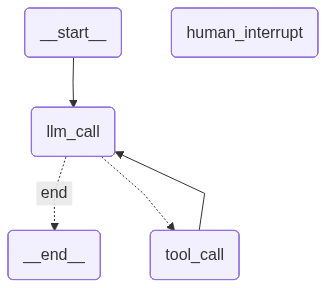

In [8]:
compiled_graph


In [9]:
thread = {'configurable': {'thread_id':'1'}}

# question = "download me vm summary document For Webtop id 464PZ8600789"
question = ' i want to download document'
input_data = {'messages':[HumanMessage(content =question )]}
result = compiled_graph.invoke(input_data, config = thread)

print(f"\n\n{result}\n\n")

print(result.get('__interrupt__'))

if result.get('__interrupt__'):

    while True:

        print(f"user input : {result.get('__interrupt__')[0].value}")
    
        user_query = result.get('__interrupt__')[0].value
    
        print('an interrupt took place')
    
        data = input(f"{user_query}")
            
        result = compiled_graph.invoke(
                Command(resume=data),
                config=thread
                )



message=None tool_call=None human_interrupt=True interrupt_question='Can you please provide the webtop ID and the document name you want to download?'


invoking interrupt




{'messages': [HumanMessage(content=' i want to download document', additional_kwargs={}, response_metadata={}, id='0b601bee-b25c-4c57-baad-7034c4e2cb0a'), AIMessage(content='Can you please provide the webtop ID and the document name you want to download?', additional_kwargs={}, response_metadata={}, id='7c391236-6f35-44f9-8bbd-23c1f165f4d5')], 'human_interrupt': True, 'interrupt_question': 'Can you please provide the webtop ID and the document name you want to download?', '__interrupt__': [Interrupt(value='Can you please provide the webtop ID and the document name you want to download?', id='b6ddea1c976388db2c54a6cb7cb8d813')]}


[Interrupt(value='Can you please provide the webtop ID and the document name you want to download?', id='b6ddea1c976388db2c54a6cb7cb8d813')]
user input : Can you please provide the webto

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# response = llm_with_tools.invoke("download the document electricity bill for webtop id 3423")

In [ ]:
result.get('__interrupt__')

In [ ]:
result.get_state(thread)

In [ ]:
all_states = [s for s in result.get_state_history(thread)]